# DTSA-5511:  Week 6 - Final Project
### October 6, 2022


## Credit Card Fraud Detection using Neural Networks
### Introduction

This is the Week 6 Final Project assignment for DTSA-5511, Introduction to Deep Learning. This applies an autoencoder neural network to a dataset of credit card transactions to determine if the transaction is fraudulent or not. The credit card transaction dataset was found on [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) and consists of 284,807 records, however only 492 of them are marked as fraudulent and all the remaining are marked valid.  

Autoencoders are a special class of neural networks that consist of an encoder section and a decoder section. The encoder section essentially down samples the supplied data into a smaller number of dimensions (or features) and the decoder expands that back to the original dimension size. In this manner the autoencoder learns how to reduce the the number of dimensions necessary for modeling the data. This is a similar function to what Principal Component Analysis (PCA) does, but PCA works best when there are linear relationships between the dimensions and the target output (valid or fraud) while autoencoders are not subect to this restriction.  

This distinction is important with the dataset used in this project as there are 28 columns in the dataset which are simply named V1 - V28 with no explanation as to what the values in these columns mean or represent. By using an autoencoder we should be able to achieve good results without needing to determine if linear relationships are present.

Finally, this Jupyter notebook can be downloaded from https://github.com/clayv/DTSA-5511_Final.


In [1]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Activation, Dense, Dropout
from keras.layers import Flatten, MaxPooling2D, Rescaling
from keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
#import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [2]:
print("Keras version:",keras.__version__)
print("TensorFlow version:",tf.__version__)
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    #print("\n", gpu_info)
    print("Connected to a GPU")

Keras version: 2.10.0
TensorFlow version: 2.10.0
Connected to a GPU


In [3]:
#Gloabals
DATA_DIR = "./data"
LABELS = ["Valid", "Fraud"]
ENCODER_ACTIVATION = "selu"
RANDOM_SEED = 42
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

### The Dataset$^1$
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, with only 492 fraudulent transactions out of 284,807 transactions.  

It contains only numerical input variables which are the result of a PCA transformation. Due to confidentiality issues, the original features cannot be provided and more background information about the data is not available. Features V1, V2, …, V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

**References**  
$^1$Kaggle. Credit Card Fraud Detection. https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud


In [4]:
df_cc_all = pd.read_csv(os.path.join(DATA_DIR, "creditcard.csv"))

### Exploratory Data Analysis
After the loading the data, well display the number of records in the the dataset and use the describe function to display some basic information about each feature/column and the head(2) function to display 2 rows.

In [5]:
print("Records in dataset: {0}\n".format(len(df_cc_all)))
print(df_cc_all.describe())
df_cc_all.head(2)

Records in dataset: 284807

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.918649e-15  5.682686e-16 -8.761736e-15  2.811118e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552103e-15  2.040130e-15 -1.698953e-15 -1.893285e-16 -3.147640e-15   
std    1.38024

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


Next we'll make a pie plot to verify the classification counts as given in the data description on Kaggle. The plot confirms that of the 284, 807 records there are 492 transactions labeled as fraudulent and the remaining 284,315 as valid. This means that only $\approx$0.17% of the transactions are labled as fraudulent.

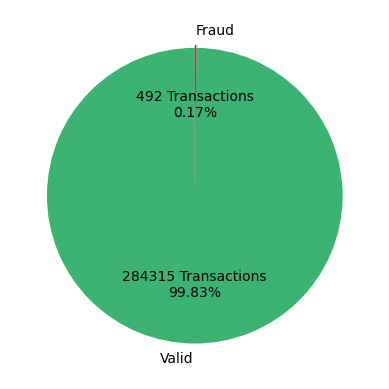

In [6]:
def makePiePlot(df):
    values = [len(df[df.Class == 0]), len(df[df.Class == 1])]
    plt.pie(values, explode = [.01, .01], labels = LABELS, colors = ['mediumseagreen', 'crimson'], 
            autopct = (lambda value:f'{value * sum(values) / 100 :.0f} Transactions\n{value:.2f}%'), 
            pctdistance = 0.6, shadow = False, labeldistance = 1.1, startangle = 90, 
            radius = 1, counterclock = True, wedgeprops = None, textprops = None, center = (0, 0), 
            frame = False, rotatelabels = False, normalize = True, data = None)
    plt.show()

makePiePlot(df_cc_all)


As we have no information regarding features V1 - V28, this next cell iterates over all the features, except for "Class", and displays the density histogram of both the valid and fraudulent transactions for each feature. This may be useful during the modeling portion of this assignment in shaping the data presented to the autoencoder to improve perfomance.

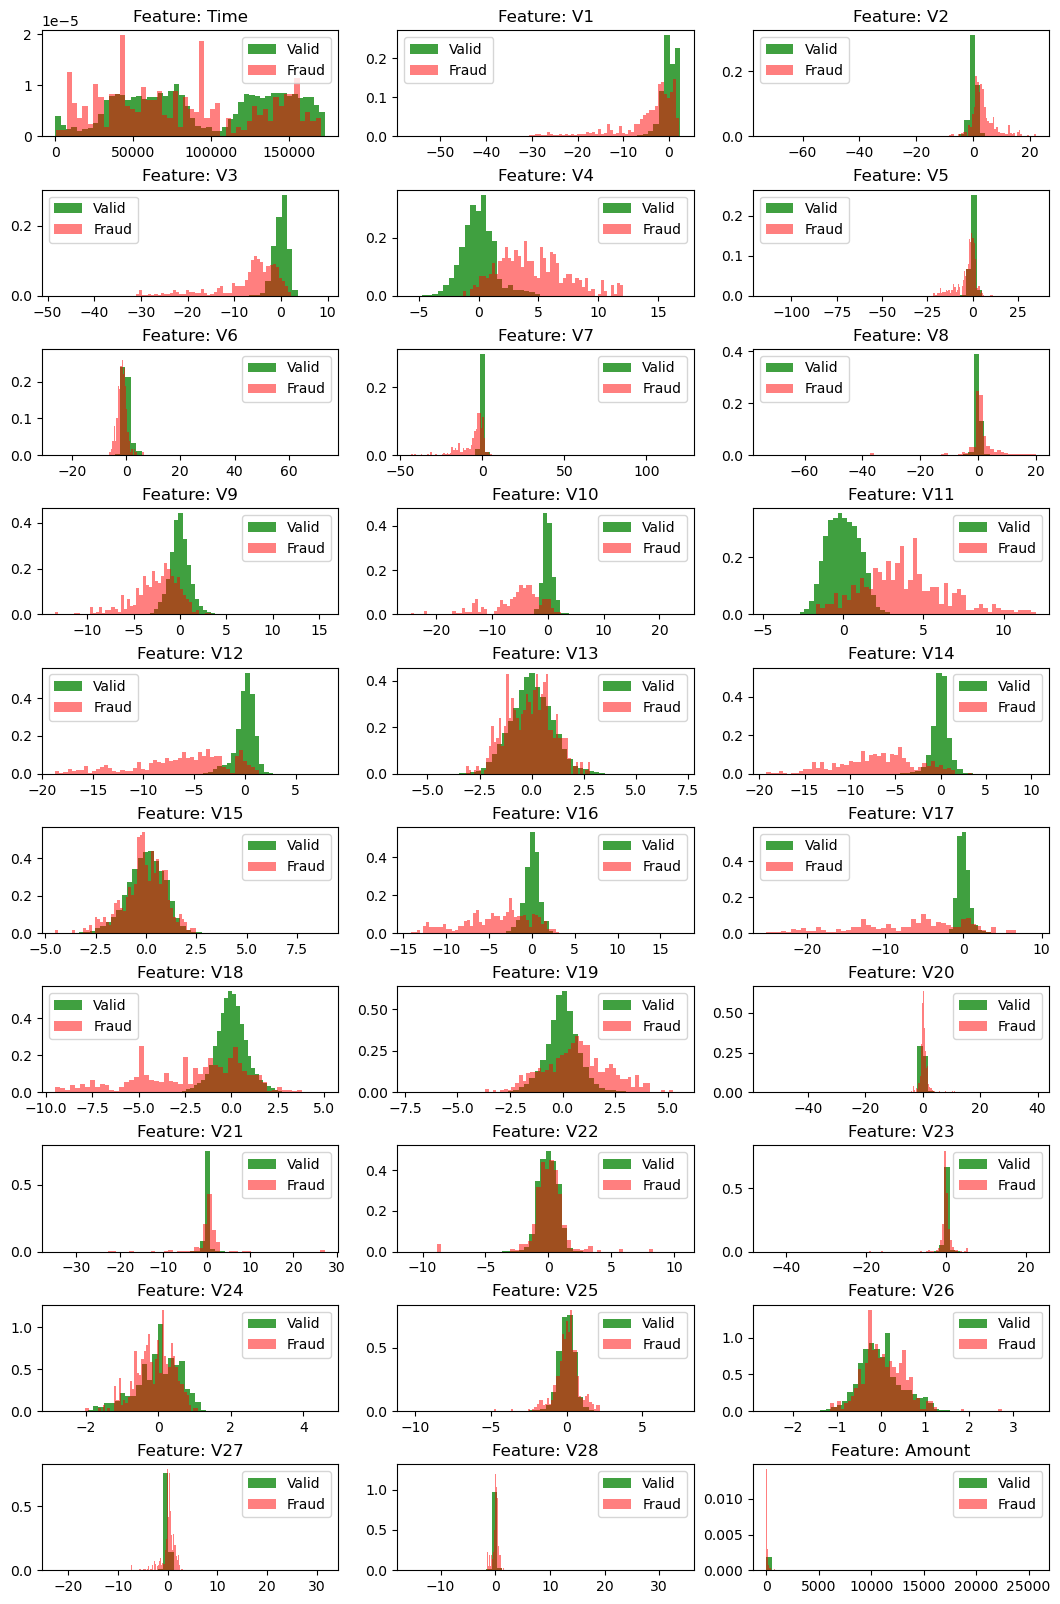

In [7]:
features = df_cc_all.columns[:-1].values

cols = 3
rows = len(features) // cols
fig, ax = plt.subplots(rows, cols, figsize=(13, 20))

for i, feature in enumerate(df_cc_all[features]):
    ax[i // cols, i % cols].hist(df_cc_all[feature][df_cc_all.Class == 0], bins=50, 
            density = True, alpha = 0.75, color = 'green', label = 'Valid')
    ax[i // cols, i % cols].hist(df_cc_all[feature][df_cc_all.Class == 1], bins=50, 
         density = True, alpha = 0.5, color = 'red', label = 'Fraud')
    ax[i // cols, i % cols].set_title('Feature: ' + str(feature))
    ax[i // cols, i % cols].legend()

plt.subplots_adjust(hspace = 0.5)
plt.show()

### Data Wrangling
The time column will be dropped because from the data description it is merely the number of seconds passed since the first record in the dataset.  Additionally, all remaining feature columns will have their values standardized as this was found to dramatically reduce the number of epochs required before the model converges.

In [8]:
df_cc_all = df_cc_all.drop('Time', axis=1)
#df_cc_all = df_cc_all.drop(['V13', 'V15', 'V20', 'V22', 'V23', 'V25', 'V26', 'V28'], axis=1)
#df_cc_all = df_cc_all.drop(['V2', 'V3', 'V5', 'V7', 'V9', 'V11', 'V12', 'V16', 'V17', 'V18'], axis=1)

features = df_cc_all.columns[:-1].values

for feature in features:
    mean, std = df_cc_all[feature].mean(), df_cc_all[feature].std()
    df_cc_all.loc[:, feature] = (df_cc_all.loc[:, feature] - mean) / std


Next a count of the smaller of the two classes (fraud) is made and then a random sample is taken of the larger of the 2 classes to create a balanced dataset.  Before using this new dataset, another pie plot is made to ensure it is now balanced.

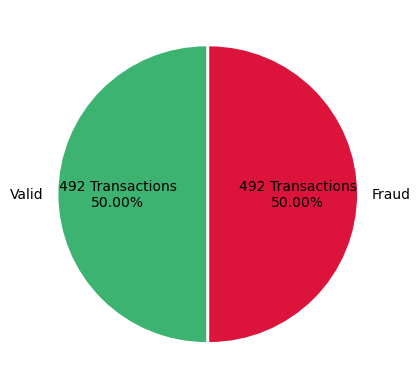

In [9]:
def getSubset(df, count, rank):
    return df[df.Class == rank].sample(n = count, replace = False, random_state = RANDOM_SEED)

lowCount = min(len(df_cc_all[df_cc_all.Class == 0]), len(df_cc_all[df_cc_all.Class == 1]))

dfValid = getSubset(df_cc_all, lowCount, 0)
dfFraud = getSubset(df_cc_all, lowCount, 1)

df_balanced = pd.concat([dfValid, dfFraud])#.sample(frac = 1, random_state = RANDOM_SEED)

makePiePlot(df_balanced)
  

A coorelation matix is created in the next cell and is show a large number of coorelated features, specifically V1 - V18 (except for V6, V13, & v15) show darker colors. Again, although no action will be taken intitially based on this information again it may be useful during the modeling portion of this assignment in shaping the data presented to the autoencoder to improve perfomance.

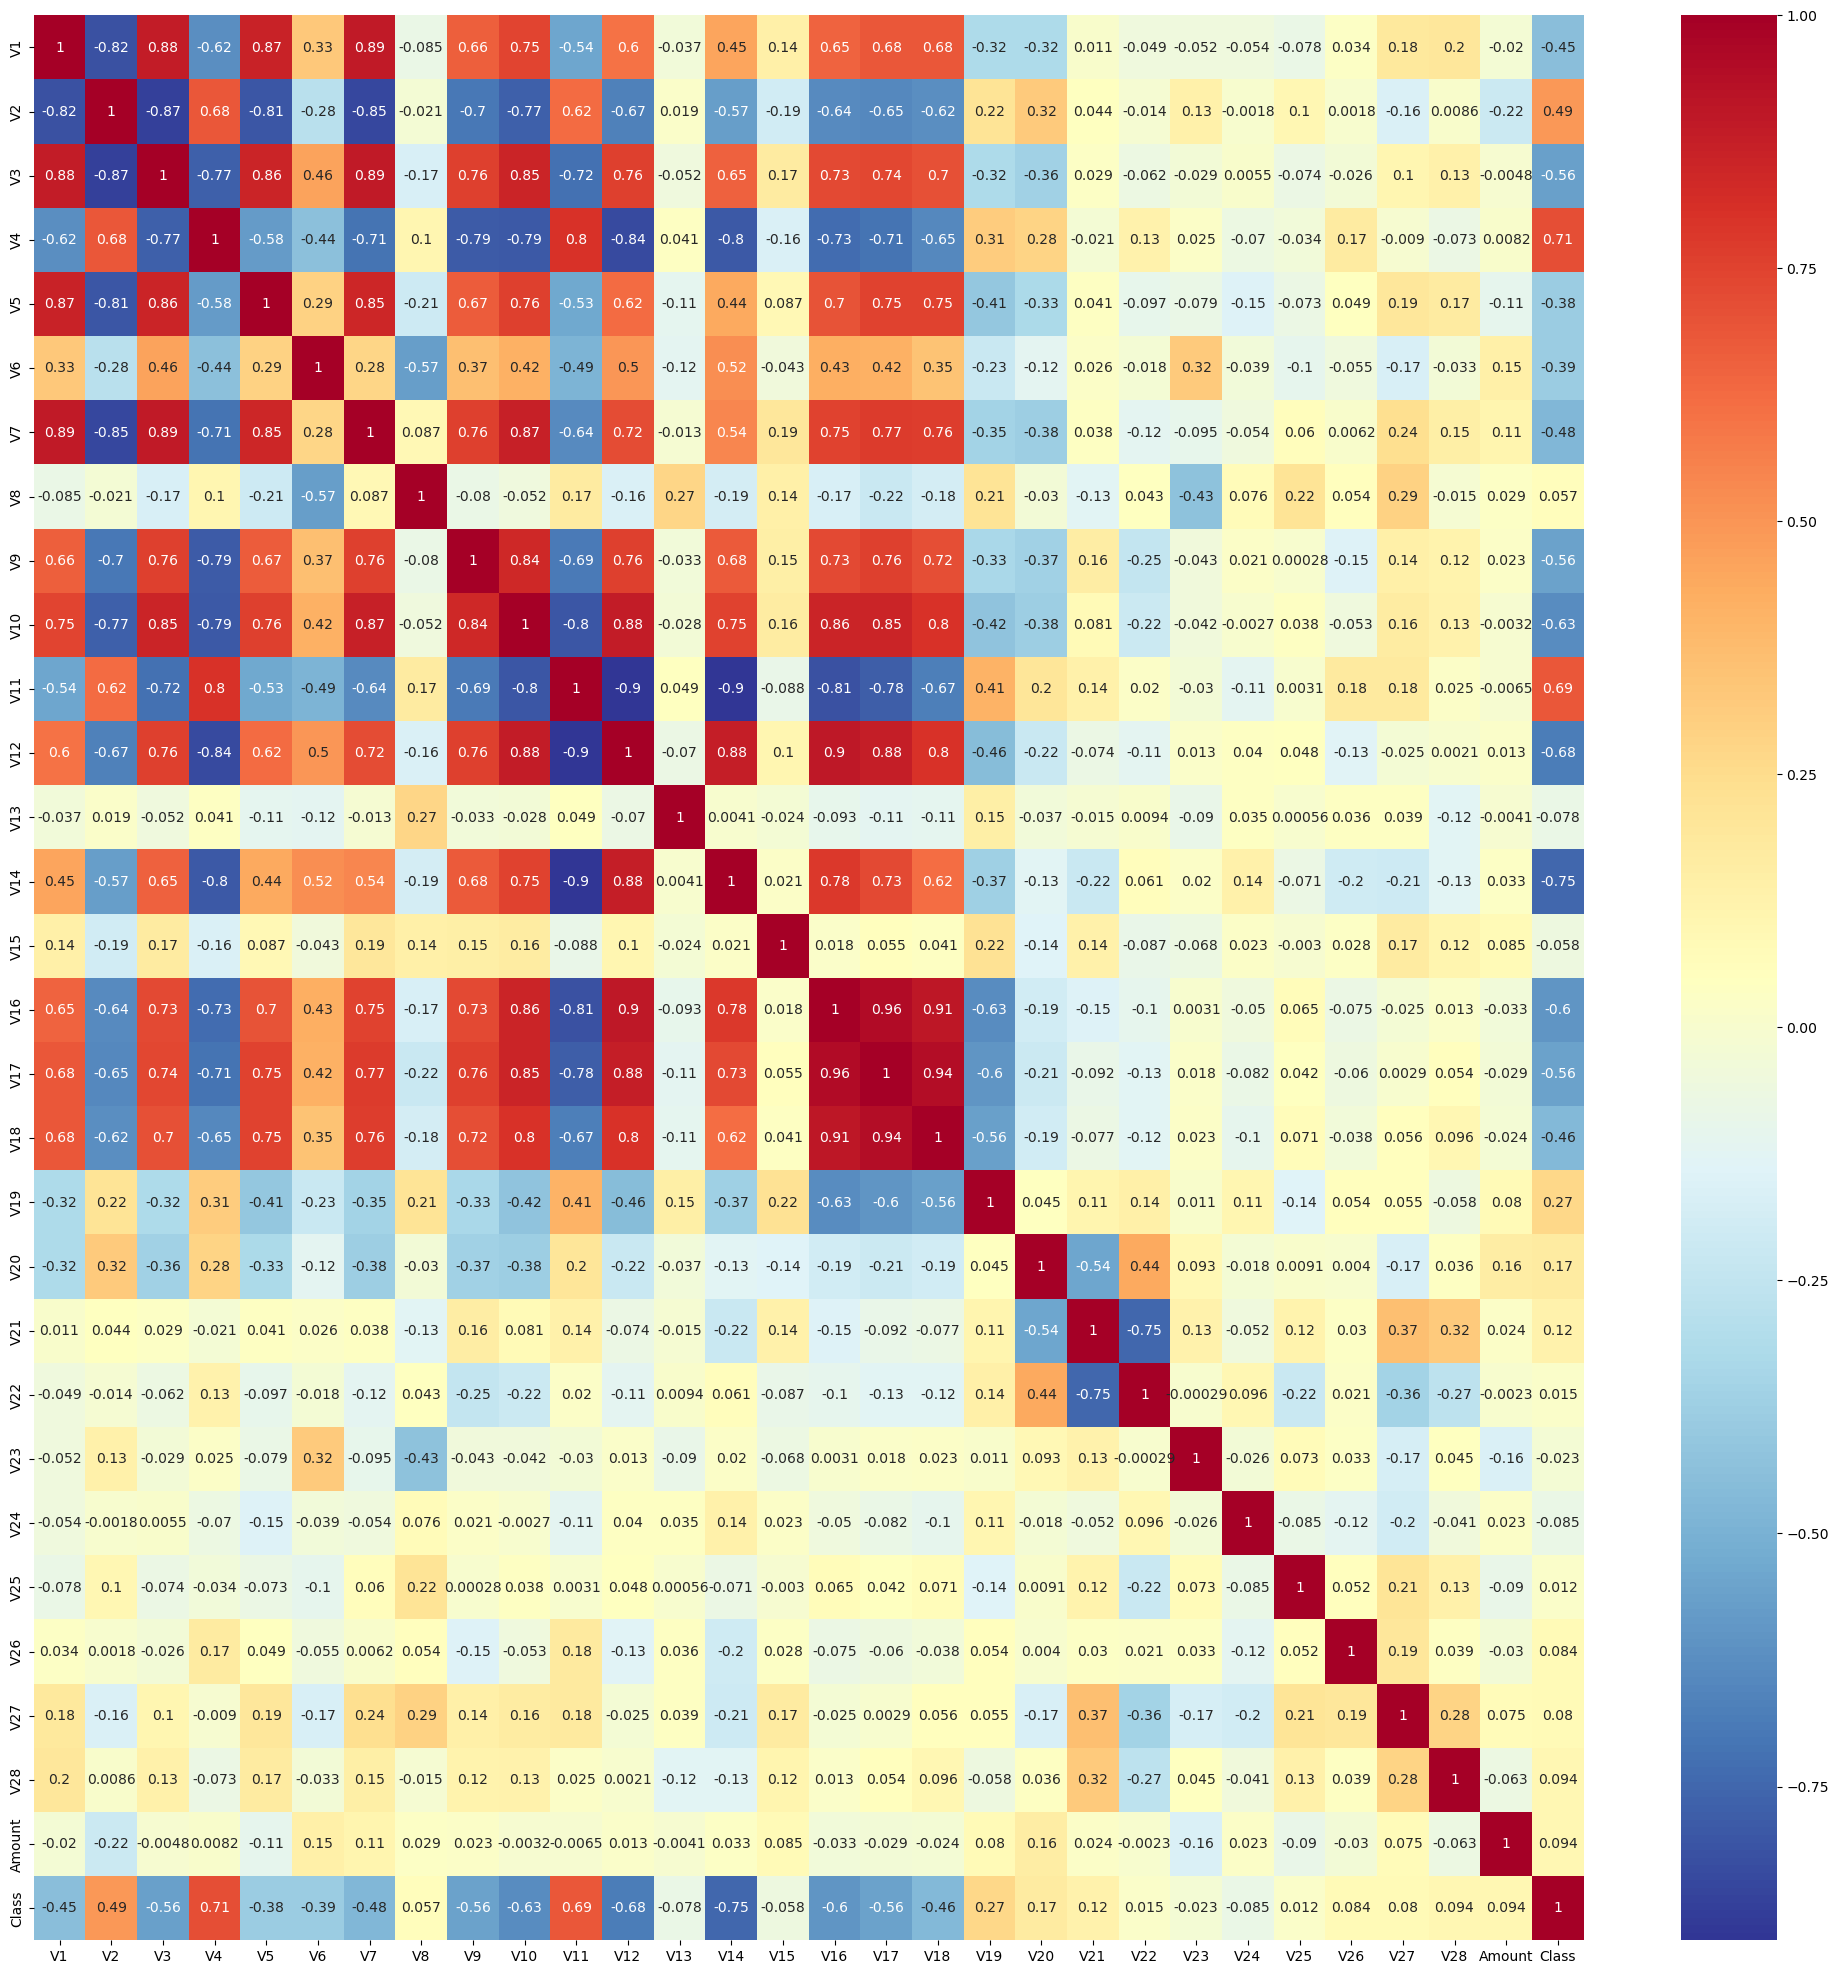

In [10]:
plt.figure(figsize = (25, 25))
sns.heatmap(df_balanced.corr(), annot = True, cmap = "RdYlBu_r")
plt.show()

### Modeling Setup
This next cell is a plotting helper function for use in creating visualization of the modeling process, how it progresses, and prediction results.

In [37]:
def plotResults(origin, history, actuals, predictions, training = True):
    if training:
        dataName = "Validation Data"
        fig, ax = plt.subplots(2, 2, figsize=(13, 10))
    else:
        dataName = "Entire Dataset:"
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    print("On the " + dataName)

    print("Accuracy: {0}\tPrecision: {1}\tRecall: {2}\tAUC: {3}".format(
        history['val_accuracy'][-1],
        history['val_precision'][-1],
        history['val_recall'][-1],
        history['val_auc'][-1],
    ))

    binaryPredictions = np.where(predictions < .5, 0, 1)
    if training:
        print("F1 Score: ", f1_score(actuals, binaryPredictions))
      
    upper = len(history['loss']) + 1

    if training:
        ax[0, 0].plot(np.arange(origin + 1, upper), history['loss'][origin:], label = 'Training')
        ax[0, 0].plot(np.arange(origin + 1, upper), history['val_loss'][origin:], label = 'Validation', color = 'red')
        ax[0, 0].set(xticks=np.arange(origin, upper, upper // 10))
        ax[0, 0].set_xlabel('Epoch')
        ax[0, 0].set_ylabel('Loss')
        ax[0, 0].set_title("Loss w/" + dataName)
        ax[0, 0].legend()

        ax[0, 1].plot(np.arange(origin + 1, upper), history['accuracy'][origin:], label = 'Training')
        ax[0, 1].plot(np.arange(origin + 1, upper), history['val_accuracy'][origin:], label = 'Validation', color = 'red')
        ax[0, 1].set(xticks=np.arange(origin, upper, upper // 10))
        ax[0, 1].set_xlabel('Epoch')
        ax[0, 1].set_title("Accuracy w/" + dataName)
        ax[0, 1].legend()

        fpr, tpr, threshold = roc_curve(actuals, predictions)
        ax[1, 0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % history['val_auc'][-1])
        ax[1, 0].set_xlabel('False Positive Rate')
        ax[1, 0].set_ylabel('True Positive Rate')
        ax[1, 0].set_title(dataName + " ROC")
        ax[1, 0].legend(loc="lower right")

        cm = confusion_matrix(actuals, binaryPredictions)

        ax[1, 1].matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax[1, 1].text(x = j, y = i, s = cm[i, j], va='center', ha='center', size='xx-large')
        ax[1, 1].set_xlabel("Confusion Matrix on\n" + dataName + "\n(0 = Negative, 1 = Positive)", fontsize = 14)
        ax[1, 1].set_ylabel('Actuals', fontsize = 12)
        ax[1, 1].set_title('Predictions', fontsize = 12)
    else:
        fpr, tpr, threshold = roc_curve(actuals, predictions)
        ax[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % history['val_auc'][-1])
        ax[0].set_xlabel('False Positive Rate')
        ax[0].set_ylabel('True Positive Rate')
        ax[0].set_title(dataName + " ROC")
        ax[0].legend(loc="lower right")

        cm = confusion_matrix(actuals, binaryPredictions)

        ax[1].matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax[1].text(x = j, y = i, s = cm[i, j], va='center', ha='center', size='xx-large')
        ax[1].set_xlabel("Confusion Matrix on\n" + dataName + "\n(0 = Negative, 1 = Positive)", fontsize = 14)
        ax[1].set_ylabel('Actuals', fontsize = 12)
        ax[1].set_title('Predictions', fontsize = 12)
        

    plt.subplots_adjust(hspace = 0.4)
    plt.show()

A split of the balanced dataset is made with 20% of the dataset be held in reserve for validating the model.

In [12]:
y = df_balanced.Class.values
X = df_balanced.drop('Class', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = RANDOM_SEED)


### Model Architecture and Design
The first model will have a 3 layer encoder and a 4 layer decoder (including the sigmoid output). As there are 29 features, then Dense layers will step down 29 -> 16 -> 8 -> 4 and then step back up 4 -> 8 -> 16 -> 29 before outputting either a 0 or 1 from the final layer with the sigmoid activation function. 

In [51]:
tf.keras.backend.clear_session()

stackedEncoder = keras.models.Sequential()
stackedEncoder.add(Dense(16, activation = ENCODER_ACTIVATION))
stackedEncoder.add(Dense(8, activation = ENCODER_ACTIVATION))
stackedEncoder.add(Dense(4, activation = ENCODER_ACTIVATION))

stackedDecoder = keras.models.Sequential()
stackedDecoder.add(Dense(8, activation = ENCODER_ACTIVATION))
stackedDecoder.add(Dense(16, activation = ENCODER_ACTIVATION))
stackedDecoder.add(Dense(len(features), activation = "relu"))
stackedDecoder.add(Dense(1, activation = "sigmoid"))

model_1 = keras.models.Sequential([stackedEncoder, stackedDecoder])
model_1.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
      loss = keras.losses.BinaryCrossentropy(from_logits = False), 
      metrics = METRICS
)

input_shape = (None, len(features))
model_1.build(input_shape)


In [52]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, 
    verbose = False, mode = 'min', min_lr = 1e-20
)
earlyStop = EarlyStopping(monitor='loss', patience = 7)

callbacks_list = [reduce_lr, earlyStop]

histModel_1 = model_1.fit(X_train, y_train, epochs = 150, validation_data = [X_test, y_test], 
    callbacks = callbacks_list, verbose = False
)

7/7 [==============================] - 0s 1ms/step
On the Validation Data
Accuracy: 0.9289340376853943	Precision: 0.9375	Recall: 0.918367326259613	AUC: 0.9734591841697693
F1 Score:  0.9278350515463918


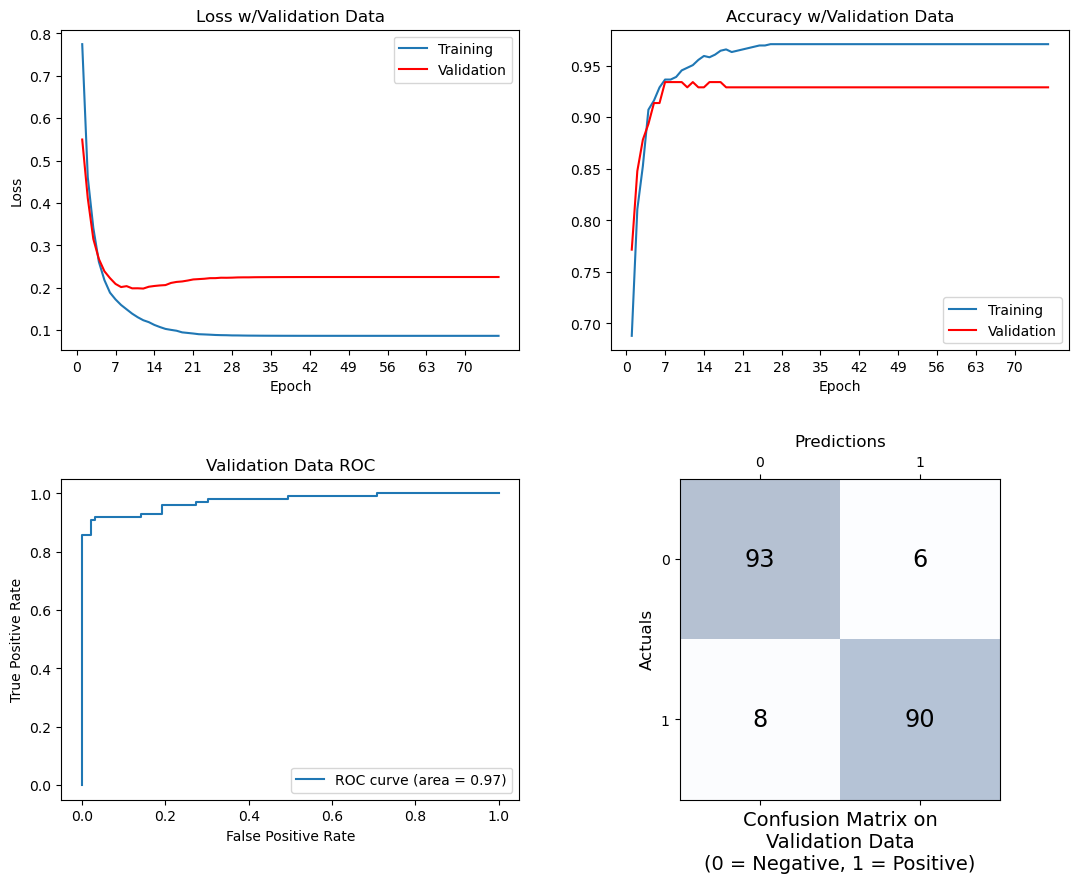

In [53]:
preds = model_1.predict(X_test)
plotResults(0, histModel_1.history, y_test, preds)

The second model will remove the Dense(8) layer from the encoder and decoder and results in the same Accuracy and very similar results for the other measures as Model 1.

7/7 [==============================] - 0s 1ms/step
On the Validation Data
Accuracy: 0.9289340376853943	Precision: 0.9468085169792175	Recall: 0.9081632494926453	AUC: 0.9788188934326172
F1 Score:  0.9270833333333334


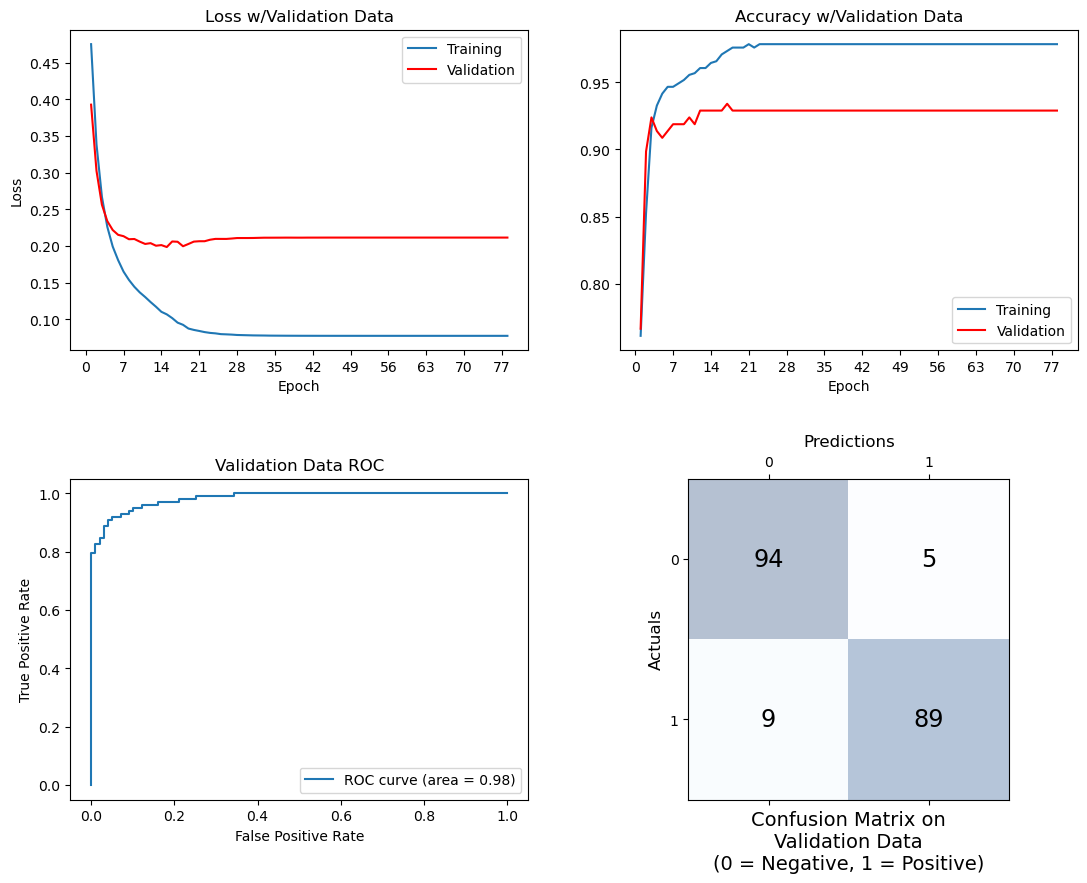

In [54]:
tf.keras.backend.clear_session()

stackedEncoder = keras.models.Sequential()
stackedEncoder.add(Dense(16, activation = ENCODER_ACTIVATION))
stackedEncoder.add(Dense(4, activation = ENCODER_ACTIVATION))

stackedDecoder = keras.models.Sequential()
stackedDecoder.add(Dense(16, activation = ENCODER_ACTIVATION))
stackedDecoder.add(Dense(len(features), activation = "relu"))
stackedDecoder.add(Dense(1, activation = "sigmoid"))

model_2 = keras.models.Sequential([stackedEncoder, stackedDecoder])
model_2.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
      loss = keras.losses.BinaryCrossentropy(from_logits = False), 
      metrics = METRICS
)

input_shape = (None, len(features))
model_2.build(input_shape)

histModel_2 = model_2.fit(X_train, y_train, epochs = 150, validation_data = [X_test, y_test], 
    callbacks = callbacks_list, verbose = False
)

plotResults(0, histModel_2.history, y_test, model_2.predict(X_test))

7/7 [==============================] - 0s 1ms/step
On the Validation Data
Accuracy: 0.9289340376853943	Precision: 0.9468085169792175	Recall: 0.9081632494926453	AUC: 0.9836631417274475
F1 Score:  0.9270833333333334


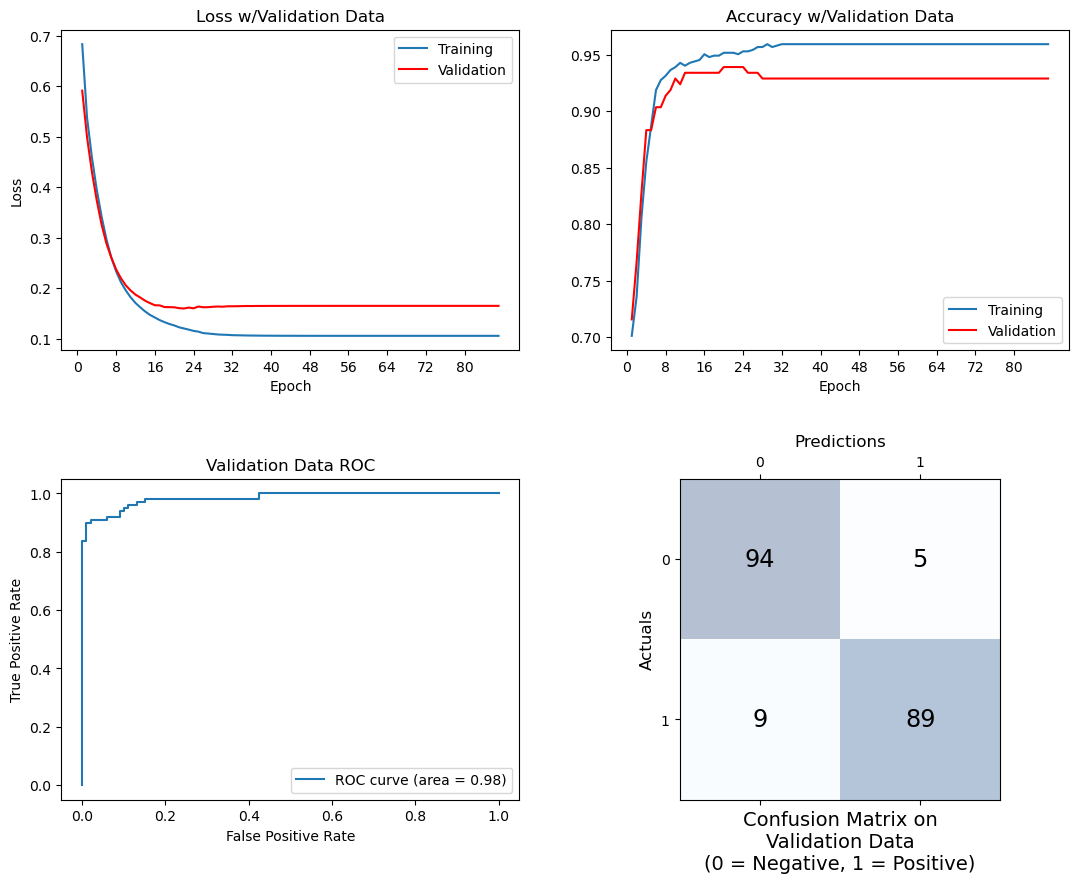

In [56]:
tf.keras.backend.clear_session()

stackedEncoder = keras.models.Sequential()
stackedEncoder.add(Dense(8, activation = ENCODER_ACTIVATION))

stackedDecoder = keras.models.Sequential()
stackedDecoder.add(Dense(len(features), activation = "relu"))
stackedDecoder.add(Dense(1, activation = "sigmoid"))

model_3 = keras.models.Sequential([stackedEncoder, stackedDecoder])
model_3.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
      loss = keras.losses.BinaryCrossentropy(from_logits = False), 
      metrics = METRICS
)

input_shape = (None, len(features))
model_3.build(input_shape)

histModel_3 = model_3.fit(X_train, y_train, epochs = 150, validation_data = [X_test, y_test], 
    callbacks = callbacks_list, verbose = False
)

plotResults(0, histModel_3.history, y_test, model_3.predict(X_test))

In [16]:
#stackedAE.save(os.path.join("./Models/", "final_model_v7.h5"))

In [41]:
#loaded = tf.keras.models.load_model(os.path.join("./Models/", "final_model_V7.h5"))
stackedAE.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 4)                 652       
                                                                 
 sequential_1 (Sequential)   (None, 1)                 707       
                                                                 
Total params: 1,359
Trainable params: 1,359
Non-trainable params: 0
_________________________________________________________________


8901/8901 [==============================] - 9s 981us/step
On the Entire Dataset:
Accuracy: 0.9390863180160522	Precision: 0.9387755393981934	Recall: 0.9387755393981934	AUC: 0.9884560108184814


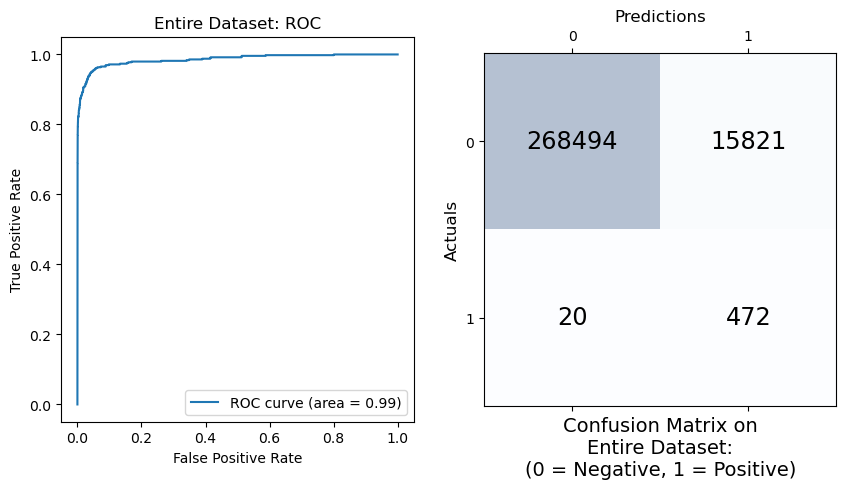

In [42]:
y_full = df_cc_all.Class.values
X_full = df_cc_all.drop('Class', axis=1).values

preds = loaded.predict(X_full)
plotResults(0, history.history, y_full, preds, training = False)


In [140]:
convModel = keras.models.Sequential()
convModel.add(tf.keras.layers.ConvLSTM1D(16, 5, activation='relu', padding = "valid"))
convModel.add(Dense(1, activation = "sigmoid"))
convModel.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
      loss = keras.losses.BinaryCrossentropy(from_logits = False), 
      metrics = METRICS
)

input_shape = (None, 30)

convModel.build(input_shape)

history = convModel.fit(X_train, y_train, epochs = 400, validation_data = [X_test, y_test], callbacks = callbacks_list, verbose = False)
preds = convModel.predict(X_test)
plotTrainingResults(history.history, y_test, preds, "Original Dataset")

ValueError: Input 0 of layer "conv_lstm1d" is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 30)

In [ ]:
tf.keras.backend.clear_session()

stackedEncoder = keras.models.Sequential()
#stackedEncoder.add(tf.keras.layers.Normalization(axis = 1))
stackedEncoder.add(Dense(16, activation = ENCODER_ACTIVATION))
#stackedEncoder.add(Dropout(.1, seed = RANDOM_SEED))
stackedEncoder.add(Dense(8, activation = ENCODER_ACTIVATION))
#stackedEncoder.add(Dense(10, activation = ENCODER_ACTIVATION))
stackedEncoder.add(Dense(4, activation = ENCODER_ACTIVATION))

stackedDecoder = keras.models.Sequential()
stackedDecoder.add(Dense(8, activation = ENCODER_ACTIVATION))
stackedDecoder.add(Dense(16, activation = ENCODER_ACTIVATION))
stackedDecoder.add(Dense(len(features), activation = "relu"))
stackedDecoder.add(Dense(1, activation = "sigmoid"))

stackedAE = keras.models.Sequential([stackedEncoder, stackedDecoder])
stackedAE.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
      loss = "mse", #keras.losses.BinaryCrossentropy(from_logits = False), 
      metrics = METRICS
)

input_shape = (None, len(features))
stackedAE.build(input_shape)